#[Exp-14] Transformer :   다양한 OCR모델 비교하기

## 목차

Step1. 검증용 데이터셋 준비

Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

Step3. 테스트 결과 정리

Step4. 결과 분석과 결론 제시

## 회고

In [1]:
# colab용 라이브러리 설치
!pip install google-api-python-client google-cloud-vision
!pip install keras_ocr matplotlib==3.3.0
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.

In [2]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.9.1
0.3.10


#Step1. 검증용 데이터셋 준비
[이미지 소스]
* 정자체(비교용)
 https://unsplash.com/s/photos/text 
* 필기체 

  : 구글 검색

#Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

## 1. keras-ocr 

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


#### 비교용 정자체 image

In [11]:
#테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/eBkEJ9cH5b4',
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

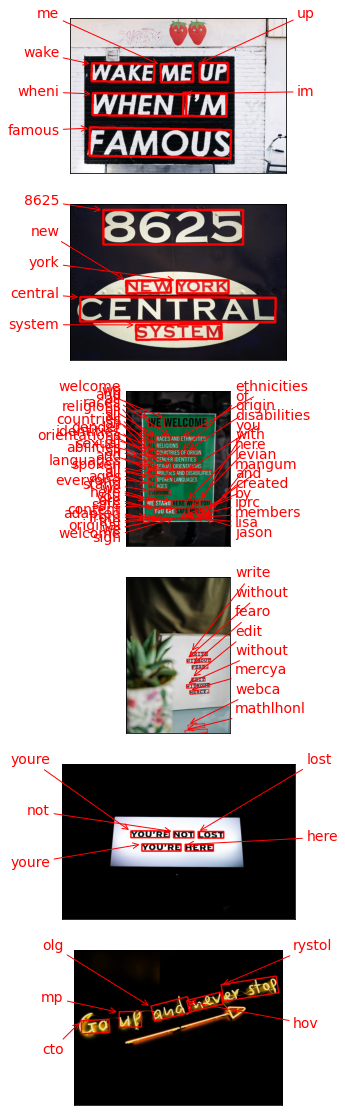

In [12]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#### 필기체 image

In [6]:
image_urls2 = [
    'https://www.howjoyful.com/wp-content/uploads/2020/12/dnealian-cursive.jpg',
    'https://larrycuban.files.wordpress.com/2020/11/maxresdefault-1.jpg?w=640',
    'https://i.pinimg.com/564x/b3/f5/31/b3f5319de97f97f48502dd882a893d79.jpg'
]

images = [ keras_ocr.tools.read(url) for url in image_urls2]
prediction_groups = [pipeline.recognize([url]) for url in image_urls2]

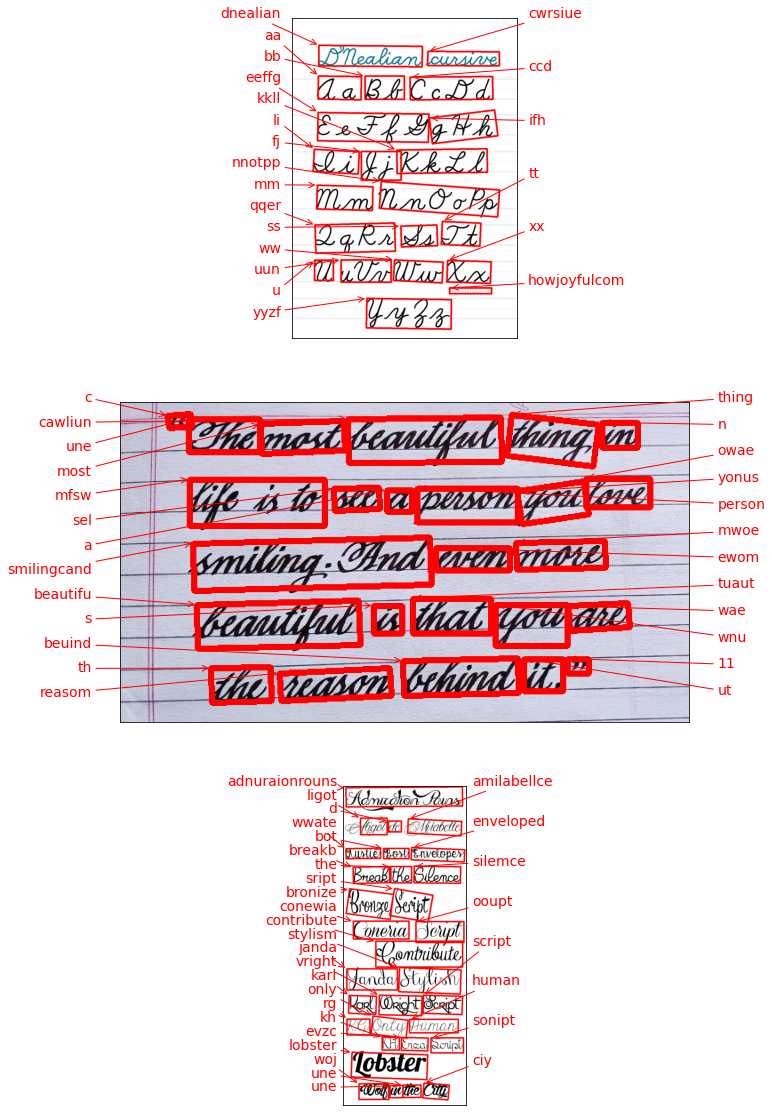

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. Tesseract

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = '/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2'
img_file_path = work_dir + '/test_image.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0000.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0001.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0002.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0003.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0004.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0005.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0006.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0007.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0008.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0009.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0010.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0011.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0012.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0013.png
/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp

In [10]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Ula BbheocDd

MY.

gi

KALA

TTl am,

Tl

mOokp

LqgRr

ds

J] 4

Uf

ui ar

Uy

‘XX,

LY YA

Done


#Step3. 테스트 결과 정리

## keras-ocr
: Qq J ... 와 같이 대문자 필기체 인식률이 떨어지지만 나머지는 비교적 정확도가 높다.

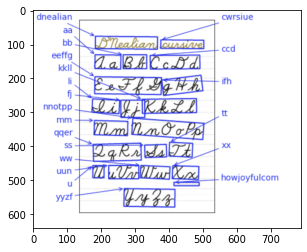

In [18]:
import cv2
img = cv2.imread('/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/PR/cursive.png')
plt.imshow(img)

## Tesseract
: (실제) Yy Zz > (모델인식결과) LY YA

나머지 알파벳도 거의 인식하지 못함.

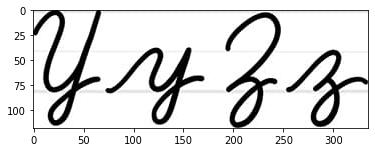

In [19]:
img2 = cv2.imread('/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp15_CV/LMS2/0014.png')
plt.imshow(img2)

#Step4. 결과 분석과 결론 제시

* 필기체 인식 : 편지나 학술적인 코멘트에는 정자체보다 필기체로 쓰여지는 경우가 많다. 아무리 정형화된 필기체라 할지라도 익숙하지 않거나 모르는 사람들에게는 이해에 큰 어려움이 따르므로 정확하게 필기체를 인식하는 OCR이 있다면 편리할것이라 생각하여 주제로 선정하였다.

keras-ocr : 정자체로는 매우 높은 정확도를 보였다. 그래서 필기체도 어느정도 괜찮은 인식률을 보일거라 예측했다. 하지만 알파벳 하나하나로는 비교적 어느정도 분석이 가능했지만, 이어쓰기가 원칙인 필기체 문장과 단어 인식에는 정확도가 2-30%에 가까웠다. 


Tesseract : 아주 기본적인 알파벳 개별 식별에도 정확도가 거의 0에 수렴했다.(필기체 알파벳[X,x] 만 인식)
문장과 단어 단위는 인식이 거의 불가능할 것으로 보인다. 실제로 필기체로 된 편지를 처음에 넣어 봤을때, 문자 자체를 잡아 내지 못하고 엉뚱한 곳을 짚는 경우가 많아 아애 삭제했다.

> 위의 이유로 아직 정확도가 한참 모자르지만 비교적 알파벳단위와 짧은 단어 인식이 가능한 keras-ocr 모델 선택했다. 


# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
특별히 어려운 점은 없었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

현재 나온 모델로는 필기체 인식이 어렵다는 사실을 알았다. 

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? |기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.|
>|2|모델 평가기준이 명확하고 체계적으로 세워졌는가?| 앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.|
>|3|평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|

### - **자기 다짐**

* 필기체 인식 OCR 모델 찾아보기